In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

class ScratchLogisticRegression():
    """
    Implementation of Logistic Regression from scratch
    
    Parameters
    ----------
    num_iter : int
        Number of iterations
    lr : float
        Learning rate
    bias : bool
        If True, include bias term
    verbose : bool
        If True, output learning process
    reg_lambda : float, default=0.0
        Regularization parameter
    
    Attributes
    ----------
    coef_ : ndarray, shape (n_features,)
        Parameters
    loss : ndarray, shape (self.iter,)
        Record of loss on training data
    val_loss : ndarray, shape (self.iter,)
        Record of loss on validation data
    """
    
    def __init__(self, num_iter=1000, lr=0.01, bias=True, verbose=False, reg_lambda=0.0):
        # Record hyperparameters as attributes
        self.iter = num_iter
        self.lr = lr
        self.bias = bias
        self.verbose = verbose
        self.reg_lambda = reg_lambda
        # Prepare arrays to record loss
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        self.coef_ = None
    
    def _sigmoid(self, z):
        """
        Sigmoid function
        
        Parameters
        ----------
        z : float or ndarray
            Input
            
        Returns
        -------
        float or ndarray
            Sigmoid function output
        """
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))  # Clip to avoid overflow
    
    def _add_bias(self, X):
        """
        Add bias term to feature matrix
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Feature matrix
            
        Returns
        -------
        ndarray, shape (n_samples, n_features + 1)
            Feature matrix with bias term
        """
        if self.bias:
            return np.hstack((np.ones((X.shape[0], 1)), X))
        return X
    
    def _compute_loss(self, X, y):
        """
        Compute the cross-entropy loss with regularization
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Feature matrix
        y : ndarray, shape (n_samples,)
            Target vector
            
        Returns
        -------
        float
            Loss value
        """
        m = X.shape[0]
        X_bias = self._add_bias(X)
        h = self._sigmoid(np.dot(X_bias, self.coef_))
        
        # Handle potential numerical issues
        epsilon = 1e-15
        h = np.clip(h, epsilon, 1 - epsilon)
        
        # Cross-entropy loss
        loss = -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))
        
        # Add regularization term (exclude bias term if present)
        if self.bias:
            reg_term = (self.reg_lambda / (2 * m)) * np.sum(self.coef_[1:] ** 2)
        else:
            reg_term = (self.reg_lambda / (2 * m)) * np.sum(self.coef_ ** 2)
            
        return loss + reg_term
    
    def _gradient_descent(self, X, y):
        """
        Update parameters using gradient descent
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Feature matrix
        y : ndarray, shape (n_samples,)
            Target vector
        """
        m = X.shape[0]
        X_bias = self._add_bias(X)
        h = self._sigmoid(np.dot(X_bias, self.coef_))
        
        # Compute gradient
        gradient = np.dot(X_bias.T, (h - y)) / m
        
        # Add regularization term (exclude bias term if present)
        if self.bias:
            reg_gradient = np.zeros_like(gradient)
            reg_gradient[1:] = (self.reg_lambda / m) * self.coef_[1:]
        else:
            reg_gradient = (self.reg_lambda / m) * self.coef_
        
        gradient += reg_gradient
        
        # Update parameters
        self.coef_ -= self.lr * gradient
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        Train logistic regression. If validation data is provided, calculate loss and accuracy for each iteration.
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Training data features
        y : ndarray, shape (n_samples,)
            Training data targets
        X_val : ndarray, shape (n_samples, n_features)
            Validation data features
        y_val : ndarray, shape (n_samples,)
            Validation data targets
        """
        # Initialize coefficients
        n_features = X.shape[1]
        if self.bias:
            self.coef_ = np.zeros(n_features + 1)
        else:
            self.coef_ = np.zeros(n_features)
        
        # Gradient descent iterations
        for i in range(self.iter):
            # Update parameters
            self._gradient_descent(X, y)
            
            # Compute and record loss
            self.loss[i] = self._compute_loss(X, y)
            
            # If validation data is provided, compute validation loss
            if X_val is not None and y_val is not None:
                self.val_loss[i] = self._compute_loss(X_val, y_val)
                
                if self.verbose and (i % 100 == 0 or i == self.iter - 1):
                    y_pred = self.predict(X)
                    y_val_pred = self.predict(X_val)
                    train_acc = accuracy_score(y, y_pred)
                    val_acc = accuracy_score(y_val, y_val_pred)
                    print(f'Iteration {i+1}/{self.iter}, Train Loss: {self.loss[i]:.6f}, Train Accuracy: {train_acc:.6f}, '
                          f'Val Loss: {self.val_loss[i]:.6f}, Val Accuracy: {val_acc:.6f}')
            elif self.verbose and (i % 100 == 0 or i == self.iter - 1):
                y_pred = self.predict(X)
                train_acc = accuracy_score(y, y_pred)
                print(f'Iteration {i+1}/{self.iter}, Train Loss: {self.loss[i]:.6f}, Train Accuracy: {train_acc:.6f}')
        
        return self
    
    def predict_proba(self, X):
        """
        Estimate probability using logistic regression.
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Samples
            
        Returns
        -------
        ndarray, shape (n_samples,)
            Estimated probabilities using logistic regression
        """
        X_bias = self._add_bias(X)
        return self._sigmoid(np.dot(X_bias, self.coef_))
    
    def predict(self, X):
        """
        Estimate labels using logistic regression.
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Samples
            
        Returns
        -------
        ndarray, shape (n_samples,)
            Estimated labels using logistic regression
        """
        return (self.predict_proba(X) >= 0.5).astype(int)
    
    def save_weights(self, filename):
        """
        Save model weights to file
        
        Parameters
        ----------
        filename : str
            File name to save weights
        """
        with open(filename, 'wb') as f:
            pickle.dump(self.coef_, f)
            
    def load_weights(self, filename):
        """
        Load model weights from file
        
        Parameters
        ----------
        filename : str
            File name to load weights
        """
        with open(filename, 'rb') as f:
            self.coef_ = pickle.load(f)

In [6]:
# Verification and visualization
def plot_learning_curve(model):
    """
    Plot learning curve (loss vs. iterations)
    
    Parameters
    ----------
    model : ScratchLogisticRegression
        Trained model
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, model.iter + 1), model.loss, label='Training Loss')
    if np.any(model.val_loss):
        plt.plot(range(1, model.iter + 1), model.val_loss, label='Validation Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_decision_boundary(model, X, y, feature_names=None):
    """
    Plot decision boundary for 2D data
    
    Parameters
    ----------
    model : ScratchLogisticRegression
        Trained model
    X : ndarray, shape (n_samples, 2)
        Features (must be 2D)
    y : ndarray, shape (n_samples,)
        Targets
    feature_names : list, optional
        Names of features
    """
    if X.shape[1] != 2:
        raise ValueError("This function only works for 2D feature data")
    
    # Create mesh grid
    h = 0.02  # step size
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Make predictions on the mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=80)
    
    # Set labels
    if feature_names is not None:
        plt.xlabel(feature_names[0])
        plt.ylabel(feature_names[1])
    else:
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        
    plt.title('Decision Boundary')
    plt.colorbar()
    plt.grid(True)
    plt.show()

In [7]:
def compare_with_sklearn(X_train, y_train, X_test, y_test, scratch_model, sk_model):
    """
    Compare scratch implementation with scikit-learn
    
    Parameters
    ----------
    X_train : ndarray
        Training features
    y_train : ndarray
        Training targets
    X_test : ndarray
        Test features
    y_test : ndarray
        Test targets
    scratch_model : ScratchLogisticRegression
        Scratch implementation
    sk_model : sklearn.linear_model.LogisticRegression
        Scikit-learn implementation
    """
    # Train models
    scratch_model.fit(X_train, y_train)
    sk_model.fit(X_train, y_train)
    
    # Get predictions
    scratch_pred = scratch_model.predict(X_test)
    sk_pred = sk_model.predict(X_test)
    
    # Calculate metrics
    scratch_acc = accuracy_score(y_test, scratch_pred)
    sk_acc = accuracy_score(y_test, sk_pred)
    
    scratch_prec = precision_score(y_test, scratch_pred)
    sk_prec = precision_score(y_test, sk_pred)
    
    scratch_rec = recall_score(y_test, scratch_pred)
    sk_rec = recall_score(y_test, sk_pred)
    
    print("Comparison of Scratch vs. Scikit-learn Implementation")
    print("=" * 50)
    print(f"{'Metric':<15} {'Scratch':<15} {'Scikit-learn':<15}")
    print("-" * 50)
    print(f"{'Accuracy':<15} {scratch_acc:<15.4f} {sk_acc:<15.4f}")
    print(f"{'Precision':<15} {scratch_prec:<15.4f} {sk_prec:<15.4f}")
    print(f"{'Recall':<15} {scratch_rec:<15.4f} {sk_rec:<15.4f}")
    print("=" * 50)


[Problem 5] Training and inference
Iteration 1/1000, Train Loss: 0.652863, Train Accuracy: 0.885714
Iteration 101/1000, Train Loss: 0.179438, Train Accuracy: 0.971429
Iteration 201/1000, Train Loss: 0.126112, Train Accuracy: 0.971429
Iteration 301/1000, Train Loss: 0.102863, Train Accuracy: 0.971429
Iteration 401/1000, Train Loss: 0.089930, Train Accuracy: 0.985714
Iteration 501/1000, Train Loss: 0.081774, Train Accuracy: 1.000000
Iteration 601/1000, Train Loss: 0.076212, Train Accuracy: 1.000000
Iteration 701/1000, Train Loss: 0.072211, Train Accuracy: 1.000000
Iteration 801/1000, Train Loss: 0.069221, Train Accuracy: 1.000000
Iteration 901/1000, Train Loss: 0.066920, Train Accuracy: 1.000000
Iteration 1000/1000, Train Loss: 0.065126, Train Accuracy: 1.000000
Comparison of Scratch vs. Scikit-learn Implementation
Metric          Scratch         Scikit-learn   
--------------------------------------------------
Accuracy        0.9000          0.9000         
Precision       0.8571     

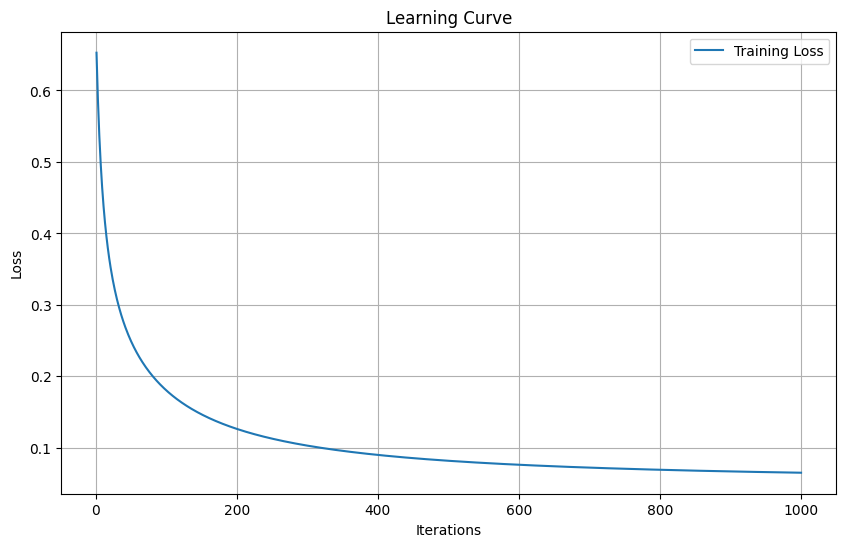


[Problem 7] Visualization of decision regions


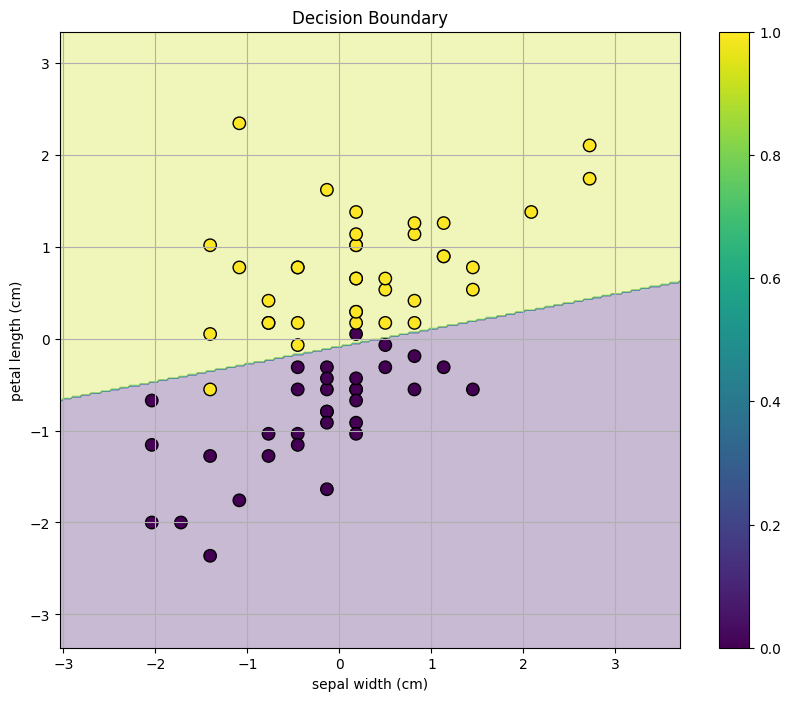


[Problem 8] Save and load weights
Weights saved to 'logistic_regression_weights.pkl'
Accuracy after loading weights: 0.9000
Success! The loaded model makes identical predictions to the original model.


In [9]:
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

X = X[y != 0]
y = y[y != 0]
y = y - 1  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# [Problem 5] Training and inference
print("\n[Problem 5] Training and inference")
print("=" * 50)

# Initialize models
scratch_model = ScratchLogisticRegression(num_iter=1000, lr=0.1, bias=True, verbose=True, reg_lambda=0.1)
sk_model = SklearnLogisticRegression(random_state=42)

# Compare models
compare_with_sklearn(X_train_scaled, y_train, X_test_scaled, y_test, scratch_model, sk_model)

# Make predictions with scratch model
y_pred = scratch_model.predict(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("\nDetailed metrics for scratch model:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# [Problem 6] Plot learning curve
print("\n[Problem 6] Plot learning curve")
print("=" * 50)
plot_learning_curve(scratch_model)

# [Problem 7] Visualization of decision regions using 2 features
print("\n[Problem 7] Visualization of decision regions")
print("=" * 50)

# We'll select sepal width (feature 1) and petal length (feature 2) for visualization
X_2d_train = X_train_scaled[:, [1, 2]]  # sepal width and petal length
X_2d_test = X_test_scaled[:, [1, 2]]

# Train a model on just these 2 features
scratch_model_2d = ScratchLogisticRegression(num_iter=1000, lr=0.1, bias=True, verbose=False)
scratch_model_2d.fit(X_2d_train, y_train)

# Plot decision boundary
plot_decision_boundary(
    scratch_model_2d, 
    X_2d_train, 
    y_train, 
    feature_names=[iris.feature_names[1], iris.feature_names[2]]
)

# [Problem 8] Save and load weights
print("\n[Problem 8] Save and load weights")
print("=" * 50)

# Save weights
scratch_model.save_weights('logistic_regression_weights.pkl')
print("Weights saved to 'logistic_regression_weights.pkl'")

# Load weights to a new model
new_model = ScratchLogisticRegression()
new_model.load_weights('logistic_regression_weights.pkl')

# Verify the loaded model works correctly
y_pred_new = new_model.predict(X_test_scaled)
new_accuracy = accuracy_score(y_test, y_pred_new)
print(f"Accuracy after loading weights: {new_accuracy:.4f}")

if np.array_equal(y_pred, y_pred_new):
    print("Success! The loaded model makes identical predictions to the original model.")
else:
    print("Error: The loaded model makes different predictions than the original model.")